In [1]:
import requests
import io
import zipfile

import numpy as np
import pandas as pd
import pydotplus

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO  

import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart
from IPython.display import Image  

c:\users\mateusz\desktop\mimuw\interpretableml\imlteam5\venv\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Na początku robimy to samo co w pracy domowej 1

tylko tym razem w Pythonie...

In [2]:
url = 'https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip'
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as tmp_zip:
    for zip_file in tmp_zip.infolist():
        with tmp_zip.open(zip_file, 'r') as f:
            stata_file = io.BytesIO(f.read())

In [3]:
stata_file.seek(0)
data = pd.read_stata(stata_file)

# Obrabiamy dane jak poprzednio


In [4]:
data = data[['S1', 'Q9', 'Q19', 'Q26', 'ppage']]

In [5]:
for column in data.columns:
    data = data[data[column] != 'Refused']
    data[column].cat.remove_unused_categories()
data = data.dropna()
data[['Q9', 'ppage']] = data[['Q9', 'ppage']].apply(pd.to_numeric, axis=1)

In [6]:
data.sample(5)

,S1,Q9,Q19,Q26,ppage
3028,"Yes, I am Married",64.0,Yes,Did not attend same college or university,62.0
884,"Yes, I am Married",42.0,Yes,Did not attend same college or university,51.0
3004,"Yes, I am Married",64.0,Yes,Did not attend same college or university,56.0
2200,"No, I am not Married",22.0,No,Did not attend same college or university,23.0
2522,"No, I am not Married",51.0,Yes,Did not attend same college or university,53.0


In [7]:
y = data['S1']
x = data.drop('S1', axis=1)

# Robimy modele

## Las losowy

In [8]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)

le_q19 = LabelEncoder()
x['Q19'] = le_q19.fit_transform(x['Q19'])

le_q26 = LabelEncoder()
x['Q26'] = le_q26.fit_transform(x['Q26'])

In [9]:
ohe = OneHotEncoder(categorical_features=[1, 2], 
                    dtype=np.int64,
                    sparse=False)
x = pd.DataFrame(ohe.fit_transform(x.values))
x.columns = ['Q19_0', 'Q19_1', 'Q26_0', 'Q26_1', 'Q9', 'ppage']

c:\users\mateusz\desktop\mimuw\interpretableml\imlteam5\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
c:\users\mateusz\desktop\mimuw\interpretableml\imlteam5\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:450: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [10]:
x.drop(['Q19_0', 'Q26_0'], axis=1, inplace=True)
x.head()

,Q19_1,Q26_1,Q9,ppage
0,1,1,52,55
1,1,1,45,47
2,1,1,59,59
3,1,1,65,65
4,1,1,43,33


In [11]:
rfc = RandomForestClassifier(max_depth=4,
                             n_estimators=30,
                             max_features=None)
rfc.fit(x, y)

y_pred = rfc.predict(x)
accuracy_score(y, y_pred)

0.8761844598862919

## SVM z jądrem gaussowskim

In [12]:
svm = SVC(probability=True)

svm.fit(x, y)

y_pred = svm.predict(x)
accuracy_score(y, y_pred)

c:\users\mateusz\desktop\mimuw\interpretableml\imlteam5\venv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8755527479469362

# Wyjaśniamy modele obliczając perturbation delta loss

In [13]:
class PerturbationLossVisualizer(object):
    def __init__(self, clf1, clf2, X, y):
        self.clf1 = clf1
        self.clf2 = clf2
        self.X = X
        self.y = y
    
    def _calculate_perturbation_losses(self, clf_no):
        assert clf_no in (1, 2)
        clf = self.clf1 if clf_no == 1 else self.clf2
        y_pred = clf.predict(self.X)
        accuracy_base = accuracy_score(self.y, y_pred)
        permutational_losses = []

        for column in self.X.columns:
            # permute column values
            tmp = self.X.copy()
            col = tmp[column].values
            np.random.shuffle(col)
            tmp[column] = col
            
            # calculate accuracy on dataset with permutated variable
            y_pred = clf.predict(tmp)
            accuracy = accuracy_score(self.y, y_pred)
            
            # add delta to result
            permutational_losses += [accuracy_base - accuracy]

        return permutational_losses
    
    def draw_permutational_loss_importance_plot(self):
        permutational_losses1 = self._calculate_perturbation_losses(1)
        permutational_losses2 = self._calculate_perturbation_losses(2)
        
        # draw the importance plot
        indices = np.argsort(np.array(permutational_losses1))[::-1]
        bar_width = 0.25
    
    
        plt.figure()
        plt.title("Permutational loss feature importances")
        plt.bar(np.arange(self.X.shape[1]), 
                np.array(permutational_losses1)[indices],
                color="b", 
                width=bar_width,
                label="clf1",
                align="center")
        plt.bar(np.arange(self.X.shape[1]) + bar_width, 
                np.array(permutational_losses2)[indices],
                color="y", 
                width=bar_width,
                label="clf2",
                align="center")
        plt.xticks(range(self.X.shape[1]), list(np.array(self.X.columns)[indices]))
        plt.xlim([-1, self.X.shape[1]])
        plt.legend()
        plt.show()   
        
        return

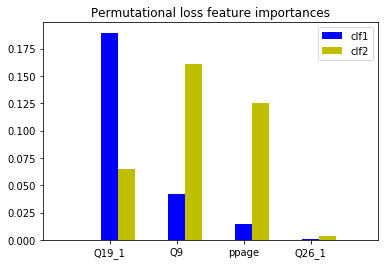

In [14]:
plv_rfc = PerturbationLossVisualizer(rfc, svm, x, y)
plv_rfc.draw_permutational_loss_importance_plot()

Porównując obydwa wykresy widzimy, że poza niską wartością dla zmiennej Q26_1, pozostałe zmienne są traktowane przez model z różnymi priorytetami. Dla lasu losowego najważniejszą zmienną jest zmienna Q19_1, natomiast pozostałe zmienne odgrywają marginalną rolę. W przypadku maszyny wektorów wspierających istotne są zmienne Q9 i ppage, natomiast zmienna Q19_1 odgrywa drugorzędną rolę. 

W naszym przypadku zmienne Q9 i ppage są silnie skorelowane, zatem SVM korzysta z nich 'po równo', natomiast las losowy najprawdopodobniej umieszcza w korzeniu każdego drzewa decyzyjnego zmienną Q19_1, stąd jej zaburzenie istotnie wpływa na predykcje modelu.

# Zobaczmy co się dzieje dla najbardziej różnicującej zmiennej

Jest to zmienna 'ppage'.

In [15]:
class CeterisParibusPlotter(object):
    def __init__(self, clf, x):
        self.clf = clf
        self.x = x
        
    def draw_ceteris_paribus_plot(self, observation, column):
        mini, maxi = int(min(self.x[column])), int(max(self.x[column]))
        original_position = observation[column].loc[0]
        print(original_position)
        ranges = []
        scores = []
        i = 0
        
        # find scores for all hypotetical observations
        for value in range(mini, maxi + 1):
            observation[column] = value
            score = self.clf.predict_proba(observation)[0, 1]
            if value == original_position:
                original_score = score
                
            scores.append(score)
            ranges.append(i)
            i += 1

        # draw the plot
        plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=range(mini, maxi + 1),
                          y=scores)
        ax.set_title('Ceteris Paribus profile for variable {}'.format(column))
        ax.set_ylabel(column)
        
        plt.scatter(x=[original_position], y=[original_score], marker='o', s=100)
        plt.show()
        
        return

In [16]:
class AccumulatedLocalEffectsPlotter(CeterisParibusPlotter):
    def draw_accumulated_local_effects_plot(self, column, window_size=1):
        mini, maxi = int(min(self.x[column])), int(max(self.x[column]))
        ale = []
        
        # find ALE statistics
        for value in range(mini, maxi + 1):
            neighbours = self.x[(self.x[column] >= value - window_size) &
                                (self.x[column] <= value + window_size)].copy()
            
            neighbours[column] = value - window_size
            scores_lower = self.clf.predict_proba(neighbours)[:, 1]
            
            neighbours[column] = value + window_size
            scores_upper = self.clf.predict_proba(neighbours)[:, 1]
            
            
            ale.append((scores_upper - scores_lower).mean())
            
        ale = ale - np.array(ale).mean()

        # draw the plot
        plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=range(mini, maxi + 1),
                          y=ale)
        ax.set_title('Accumulated Local Effects plot for variable {}'.format(column))
        ax.set_ylabel(column)
        
        plt.show()
        return

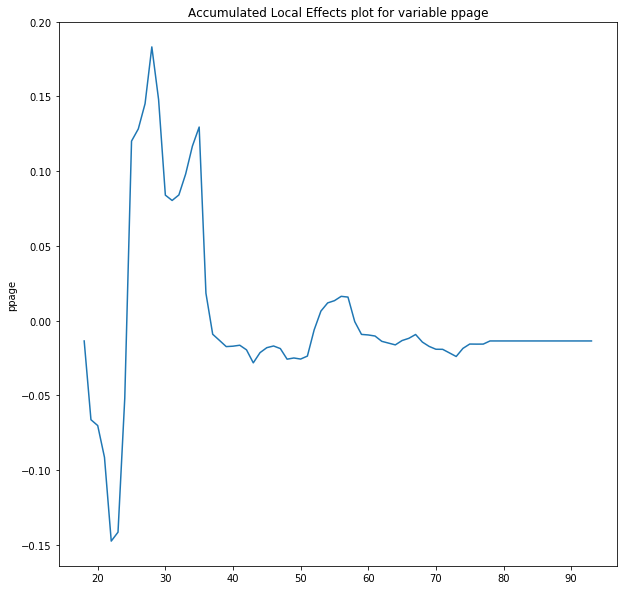

In [17]:
alep_rfc = AccumulatedLocalEffectsPlotter(rfc, x)
alep_rfc.draw_accumulated_local_effects_plot('ppage', 3)

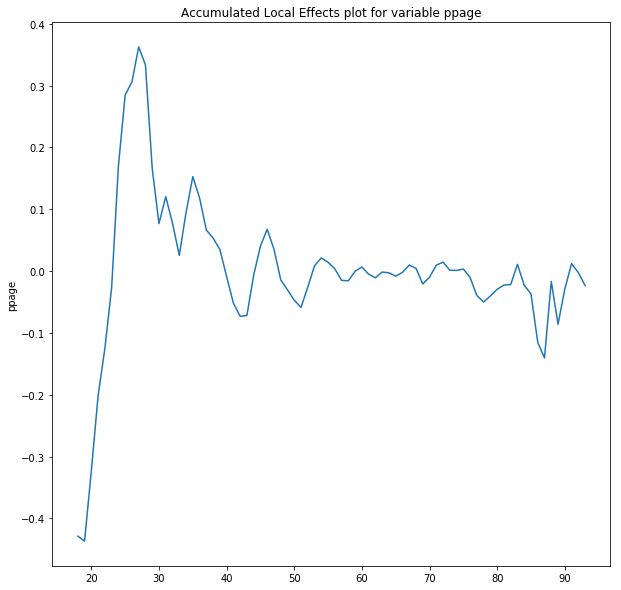

In [18]:
alep_svm = AccumulatedLocalEffectsPlotter(svm, x)
alep_svm.draw_accumulated_local_effects_plot('ppage', 3)

ALE ploty dla zmiennej 'ppage' dla obydwu modeli mają zbliżoną trajektorię. Wykres dla maszyny wektorów wspierających jest bardziej postrzępiony, co wynika z faktu, że las losowy przypisuje tej zmiennej małą wagę przy ostatecznej predykcji, natomiast SVM ma gładkie granice decyzyjne.